In [3]:
#!pip install imblearn

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline
import xgboost as xgb
from sklearn.metrics import classification_report, roc_curve, precision_recall_curve,roc_auc_score, f1_score, confusion_matrix

In [5]:
TLC_df = pd.read_csv('data\\TLC_df_final.csv')

In [6]:
TLC_df.head()

,Unnamed: 0,loan_amnt,funded_amnt,term,int_rate,grade,sub_grade,emp_length,home_ownership,annual_inc,...,revol_bal,revol_util,total_acc,mort_acc,pub_rec_bankruptcies,zip_3,zip_2,credit_hist,fico_avg_score,inst_amnt_ratio
0,0,3600.0,3600.0,1,13.99,5,21,10.0,4,55000.0,...,2765.0,29.7,13.0,1.0,0.0,190,19,4505.0,677.0,0.034175
1,1,24700.0,24700.0,1,11.99,5,24,10.0,4,65000.0,...,21470.0,19.2,38.0,4.0,0.0,577,57,5844.0,717.0,0.033210
2,4,10400.0,10400.0,2,22.45,2,9,3.0,4,104433.0,...,21929.0,64.5,35.0,6.0,0.0,174,17,6392.0,697.0,0.027876
3,5,11950.0,11950.0,1,13.44,5,22,4.0,3,34000.0,...,8822.0,68.4,6.0,0.0,0.0,300,30,10288.0,692.0,0.033906
4,6,20000.0,20000.0,1,9.17,6,28,10.0,4,180000.0,...,87329.0,84.5,27.0,4.0,0.0,550,55,9314.0,682.0,0.031879


In [7]:
target = 'loan_status'


X = TLC_df.drop(columns=[target,'zip_3','zip_2','Unnamed: 0'], axis=1)
y = TLC_df[target]

In [8]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3, random_state=11)

In [9]:
y_train.head()

80245      0
70177      0
760935     0
325461     1
1267091    0
Name: loan_status, dtype: int64

In [10]:
y_train.shape,y_test.shape

((911370,), (390588,))

In [11]:
drop_columns=['pub_rec','pub_rec_bankruptcies','purpose','revol_bal','total_acc','funded_amnt']

In [12]:
X_train=X_train.drop(columns=drop_columns)
X_test =X_test.drop(columns=drop_columns)

In [ ]:
from collections import Counter
counter = Counter(y_train)
# estimate scale_pos_weight value
estimate = counter[0] / counter[1]
print('Estimate: %.3f' % estimate)
#define the param grid
# Parameters of pipelines can be set using ‘__’ separated para
clf_grid = {
    'xgb__eta': [0.05, 0.1, 0.3],
    'xgb__max_depth': [3, 6, 12],
    'xgb__colsample_bytree': [0.9, 1.0],
    }
#define the pipeline
model_pipe = Pipeline([
    ('xgb', xgb.XGBClassifier(n_estimators=200,
                              n_jobs=-1, scale_pos_weight=estimate))
])
#define the classifer
clf = GridSearchCV(model_pipe,
                   clf_grid,
                   n_jobs=-1,
                   cv=3, 
                   verbose=50, 
                   scoring='roc_auc')
#fit to training data
clf.fit(X_train, y_train)

Estimate: 3.551
Fitting 3 folds for each of 18 candidates, totalling 54 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed: 20.7min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed: 23.4min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 25.6min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 27.8min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed: 30.1min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed: 31.8min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed: 34.8min
[Parallel(n_jobs=-1)]: Done  14 tasks    

GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('xgb',
                                        XGBClassifier(base_score=0.5,
                                                      booster='gbtree',
                                                      colsample_bylevel=1,
                                                      colsample_bynode=1,
                                                      colsample_bytree=1,
                                                      gamma=0,
                                                      learning_rate=0.1,
                                                      max_delta_step=0,
                                                      max_depth=3,
                                                      min_child_weight=1,
                                                      missing=None,
                                                      n_estimators=200,
                  

In [ ]:
print("Best model parameters: \n")
print(clf.best_params_ )
print("Best model score: \n")
print(clf.best_score_)


Best model parameters: 

{'xgb__colsample_bytree': 0.9, 'xgb__eta': 0.05, 'xgb__max_depth': 6}
Best model score: 

0.7222657367625497


In [ ]:
y_pred = clf.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[196570, 108629],
       [ 27282,  58107]])

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test,
                                 clf.predict_proba(X_test)[:,1],
                                 pos_label=1)

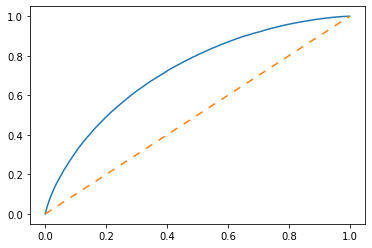

AUC: 0.723


In [ ]:
plt.plot(fpr, tpr, label='XGB')
plt.plot([0,1], [0,1], label='No Discrimination', linestyle='-', dashes=(5, 5))
plt.show()

# calculate AUC
auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])
print('AUC: %.3f' % auc)

In [ ]:
f1_xgb = f1_score(y_test, y_pred)

print("f1_xgb (binary): {}\n".format(f1_xgb))
print(classification_report(y_test,y_pred))

f1_xgb (binary): 0.46093802677243434

              precision    recall  f1-score   support

           0       0.88      0.64      0.74    305199
           1       0.35      0.68      0.46     85389

    accuracy                           0.65    390588
   macro avg       0.61      0.66      0.60    390588
weighted avg       0.76      0.65      0.68    390588



In [ ]:
#define location to save trained model
save_model_dir = os.path.join('xgb_cv_final.pkl')
print("Saving model at: {}".format(save_model_dir))

#save the model
with open(save_model_dir, 'wb') as handle:
    pickle.dump(clf,
                handle,
                protocol=3)

Saving model at: /content/drive/MyDrive/xgb_cv_final.pkl
